# Environment Configuration

In [1]:
import os

DEVICE = 'cuda:0'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 6.8 MB/s 
     |████████████████████████████████| 86 kB 3.6 MB/s 
     |████████████████████████████████| 596 kB 59.2 MB/s 
     |████████████████████████████████| 6.6 MB 53.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Data Preparation

## Download Datasets

Clone the repo containing ATIS and SNIPS and set their paths to be used later.

In [3]:
!git clone https://github.com/BrownFortress/IntentSlotDatasets.git

DATASET_PATHS = {"ATIS": "./IntentSlotDatasets/ATIS/", 
                 "SNIPS": "./IntentSlotDatasets/SNIPS/"}

Cloning into 'IntentSlotDatasets'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 40 (delta 9), reused 25 (delta 6), pack-reused 0
Unpacking objects: 100% (40/40), done.


## Load Data

Load the datasets into a dictionary `dataset[dataset_name][split]` is a list of samples containing an utterance, intent, and a slot.

In [4]:
import os
import json
from pprint import pprint

dataset = dict()

for name, path in DATASET_PATHS.items():
    dataset[name] = dict()
    for split in ["train", "test", "valid"]:
        split_path = os.path.join(path, split + ".json")
        if os.path.exists(split_path):
            with open(split_path) as fp:
                dataset[name][split] = json.load(fp)
                print(name, split, len(dataset[name][split]))

pprint(dataset['ATIS']['train'][0])

ATIS train 4978
ATIS test 893
SNIPS train 13084
SNIPS test 700
SNIPS valid 700
{'intent': 'flight',
 'slots': 'O O O O O B-fromloc.city_name O B-depart_time.time '
          'I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O '
          'B-arrive_time.period_of_day',
 'utterance': 'i want to fly from boston at 838 am and arrive in denver at '
              '1110 in the morning'}


## Lang and Dataset Classes

The `Lang` class stores information about the vocabulary and output labels. Each word/intent/slot label is mapped to an integer. These integers are then fed into the embedding layers of the neural models.

`Dataset` is for dividing the whole dataset into smaller batches.

In [6]:
import torch
import torch.utils.data as data

class Lang:
    PAD_TOKEN = '[PAD]'
    UNK_TOKEN = '[UNK]'

    def __init__(self):
        self._vocab = []
        self._word_ids = dict()
        self._intents = []
        self._intent_ids = dict()
        self._slots = []
        self._slot_ids = dict()

    def build_vocab(self, data):
        vocab = set()
        for x in data:
            vocab = vocab.union(set(x['utterance'].split()))
        self._vocab = [Lang.PAD_TOKEN] + list(vocab) + [Lang.UNK_TOKEN]
        self._word_ids = dict((w, i) for i, w in enumerate(self._vocab))

    def build_intents(self, data):
        self._intents = list(set(x['intent'] for x in data))
        self._intent_ids = dict((w, i) for i, w in enumerate(self._intents))

    def build_slots(self, data):
        slots = set()
        for x in data:
            slots = slots.union(set(x['slots'].split()))
        self._slots = list(slots)
        self._slot_ids = dict((w, i) for i, w in enumerate(self._slots))
    
    def get_word_id(self, word):
        if word in self._word_ids:
            return self._word_ids[word]
        else:
            return self._word_ids[Lang.UNK_TOKEN]
    
    def get_intent_id(self, intent):
        return self._intent_ids[intent]
    
    def get_slot_id(self, intent):
        return self._slot_ids[intent]
    
    def get_slot_label(self, i):
        return self._slots[i]

    def get_intent_label(self, i):
        return self._intents[i]
    
    def get_word(self, i):
        return self._vocab[i]
    
    @property
    def vocab_size(self):
        return len(self._vocab)
    
    @property
    def num_intents(self):
        return len(self._intents)
    
    @property
    def num_slots(self):
        return len(self._slots)
    
    @property
    def vocab(self):
        return self._vocab

class Dataset(data.Dataset):

    def __init__(self, data, lang):
        self._x = []
        self._y_intent = []
        self._y_slot = []

        for sample in data:
            utter_ids = list(map(lang.get_word_id, sample['utterance'].split()))
            slot_ids = list(map(lang.get_slot_id, sample['slots'].split()))
            self._x.append(utter_ids)
            self._y_slot.append(slot_ids)
            self._y_intent.append(lang.get_intent_id(sample['intent']))
    
    def __len__(self):
        return len(self._x)

    def __getitem__(self, i):
        x = torch.Tensor(self._x[i])
        y_intent = self._y_intent[i]
        y_slot = torch.Tensor(self._y_slot[i])
        return {'utterance': x, 'intent': y_intent, 'slots': y_slot}

def collate_fn(data):
    def merge(sequences):
        lengths = [len(seq) for seq in sequences]
        max_len = 1 if max(lengths)==0 else max(lengths)
        padded_seqs = torch.LongTensor(len(sequences),max_len).fill_(0)
        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq
        padded_seqs = padded_seqs.detach()
        return padded_seqs, lengths

    data.sort(key=lambda x: len(x['utterance']), reverse=True) 
    new_item = {}
    for key in data[0].keys():
        new_item[key] = [d[key] for d in data]
    src_utt, _ = merge(new_item['utterance'])
    y_slots, y_lengths = merge(new_item["slots"])
    intent = torch.LongTensor(new_item["intent"])
    
    src_utt = src_utt.to(DEVICE)
    y_slots = y_slots.to(DEVICE)
    intent = intent.to(DEVICE)
    y_lengths = torch.LongTensor(y_lengths).to(DEVICE)
    
    new_item["utterances"] = src_utt
    new_item["intents"] = intent
    new_item["y_slots"] = y_slots
    new_item["slots_len"] = y_lengths
    return new_item


# Bi-model RNN

Wang, Yu, Yilin Shen, and Hongxia Jin. "A bi-model based rnn semantic frame parsing model for intent detection and slot filling." arXiv preprint [arXiv:1812.10235](https://arxiv.org/abs/1812.10235) (2018).

Original code: https://github.com/ray075hl/Bi-Model-Intent-And-Slot

In [7]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiModelRNN(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_intents, num_slots, vocab_size):
        super(BiModelRNN, self).__init__()
        self._embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self._intent_enc = nn.LSTM(embed_dim, hidden_dim, 2, bidirectional=True)
        self._y_intent1 = nn.Linear(2 * hidden_dim, 2 * hidden_dim)
        self._y_intent2 = nn.Linear(2 * hidden_dim, num_intents)
        self._slot_enc = nn.LSTM(embed_dim, hidden_dim, 2, bidirectional=True)
        self._y_slot1 = nn.Linear(2 * hidden_dim, 2 * hidden_dim)
        self._y_slot2 = nn.Linear(2 * hidden_dim, num_slots)

    def forward(self, input, seq_lens):
        x = self._embed(input).permute(1, 0, 2)
        x = pack_padded_sequence(x, seq_lens.cpu().numpy())
        with torch.no_grad():
            _, (h1, s1) = self._intent_enc(x)
            _, (h2, s2) = self._slot_enc(x)
        y_intent, _ = self._intent_enc(x, (h2, s1))
        y_slot, _ = self._slot_enc(x, (h1, s2))
        y_intent = self._y_intent1(pad_packed_sequence(y_intent)[0])
        y_slot = self._y_slot1(pad_packed_sequence(y_slot)[0])
        self._h_intent, self._s_intent = h1.detach(), s1.detach()
        self._h_slot, self._s_slot = h2.detach(), s2.detach()
        return self._y_intent2(y_intent[-1,:,:]), self._y_slot2(y_slot).permute(1, 2, 0)


# Attention Bi-RNN

Liu, Bing, and Ian Lane. "Attention-based recurrent neural network models for joint intent detection and slot filling." arXiv preprint [arXiv:1609.01454](https://arxiv.org/pdf/1609.01454.pdf) (2016).

In [8]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class AttentionBiRNN(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_intents, num_slots, vocab_size):
        super(AttentionBiRNN, self).__init__()
        self._embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self._blstm = nn.LSTM(embed_dim, hidden_dim, 2, bidirectional=True)
        self._attention = nn.MultiheadAttention(2 * hidden_dim, 4)
        self._y_intent = nn.Linear(2 * hidden_dim, num_intents)
        self._y_slot = nn.Linear(2 * hidden_dim, num_slots)

    def forward(self, x, seq_lens):
        x = self._embed(x).permute(1, 0, 2)
        x = pack_padded_sequence(x, seq_lens.cpu().numpy())
        x, _ = self._blstm(x)
        x, _ = pad_packed_sequence(x)
        x, _ = self._attention(x, x, x)
        return self._y_intent(x[-1,:,:]), self._y_slot(x).permute(1, 2, 0)

# BERT

Chen, Qian, Zhu Zhuo, and Wen Wang. "Bert for joint intent classification and slot filling." arXiv preprint [arXiv:1902.10909](https://arxiv.org/abs/1902.10909) (2019).

In [9]:
import torch.nn as nn
from transformers import BertModel, BertConfig, BertTokenizer

class BERT(nn.Module):

    def __init__(self, num_intents, num_slots, lang):
        super(BERT, self).__init__()
        self._lang = lang
        self._tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', never_split=lang.vocab)
        self._tokenizer.add_tokens(lang.vocab)
        self._bert = BertModel.from_pretrained('bert-base-uncased')
        self._bert.to(DEVICE)
        self._bert.resize_token_embeddings(len(self._tokenizer))
        self._intent = nn.Linear(self._bert.config.hidden_size, num_intents)
        self._slots = nn.Linear(self._bert.config.hidden_size, num_slots)
    
    def _to_text(self, input):
        texts = []
        for sample in input:
            texts.append(' '.join(lang.get_word(i) for i in sample if i > 0))
        return texts
    
    def forward(self, input, seq_lens):
        with torch.no_grad():
            encoding = self._tokenizer(self._to_text(input),
                                        add_special_tokens=True,   
                                        truncation=True,
                                        padding=True,
                                        return_tensors="pt").to(DEVICE)
            bert_output = self._bert(**encoding)
        x_intent = bert_output.pooler_output
        x_slots = bert_output.last_hidden_state[:,:input.size()[1],:]
        return self._intent(x_intent), self._slots(x_slots).permute(0, 2, 1)

# Evaluation Script

ConLL evaluation script taken from https://github.com/sighsmile/conlleval.

In [10]:
"""
This script applies to IOB2 or IOBES tagging scheme.
If you are using a different scheme, please convert to IOB2 or IOBES.

IOB2:
- B = begin, 
- I = inside but not the first, 
- O = outside

e.g. 
John   lives in New   York  City  .
B-PER  O     O  B-LOC I-LOC I-LOC O

IOBES:
- B = begin, 
- E = end, 
- S = singleton, 
- I = inside but not the first or the last, 
- O = outside

e.g.
John   lives in New   York  City  .
S-PER  O     O  B-LOC I-LOC E-LOC O

prefix: IOBES
chunk_type: PER, LOC, etc.
"""
from __future__ import division, print_function, unicode_literals

import sys
from collections import defaultdict

def split_tag(chunk_tag):
    """
    split chunk tag into IOBES prefix and chunk_type
    e.g. 
    B-PER -> (B, PER)
    O -> (O, None)
    """
    if chunk_tag == 'O':
        return ('O', None)
    return chunk_tag.split('-', maxsplit=1)

def is_chunk_end(prev_tag, tag):
    """
    check if the previous chunk ended between the previous and current word
    e.g. 
    (B-PER, I-PER) -> False
    (B-LOC, O)  -> True

    Note: in case of contradicting tags, e.g. (B-PER, I-LOC)
    this is considered as (B-PER, B-LOC)
    """
    prefix1, chunk_type1 = split_tag(prev_tag)
    prefix2, chunk_type2 = split_tag(tag)

    if prefix1 == 'O':
        return False
    if prefix2 == 'O':
        return prefix1 != 'O'

    if chunk_type1 != chunk_type2:
        return True

    return prefix2 in ['B', 'S'] or prefix1 in ['E', 'S']

def is_chunk_start(prev_tag, tag):
    """
    check if a new chunk started between the previous and current word
    """
    prefix1, chunk_type1 = split_tag(prev_tag)
    prefix2, chunk_type2 = split_tag(tag)

    if prefix2 == 'O':
        return False
    if prefix1 == 'O':
        return prefix2 != 'O'

    if chunk_type1 != chunk_type2:
        return True

    return prefix2 in ['B', 'S'] or prefix1 in ['E', 'S']


def calc_metrics(tp, p, t, percent=True):
    """
    compute overall precision, recall and FB1 (default values are 0.0)
    if percent is True, return 100 * original decimal value
    """
    precision = tp / p if p else 0
    recall = tp / t if t else 0
    fb1 = 2 * precision * recall / (precision + recall) if precision + recall else 0
    if percent:
        return 100 * precision, 100 * recall, 100 * fb1
    else:
        return precision, recall, fb1


def count_chunks(true_seqs, pred_seqs):
    """
    true_seqs: a list of true tags
    pred_seqs: a list of predicted tags

    return: 
    correct_chunks: a dict (counter), 
                    key = chunk types, 
                    value = number of correctly identified chunks per type
    true_chunks:    a dict, number of true chunks per type
    pred_chunks:    a dict, number of identified chunks per type

    correct_counts, true_counts, pred_counts: similar to above, but for tags
    """
    correct_chunks = defaultdict(int)
    true_chunks = defaultdict(int)
    pred_chunks = defaultdict(int)

    correct_counts = defaultdict(int)
    true_counts = defaultdict(int)
    pred_counts = defaultdict(int)

    prev_true_tag, prev_pred_tag = 'O', 'O'
    correct_chunk = None

    for true_tag, pred_tag in zip(true_seqs, pred_seqs):
        if true_tag == pred_tag:
            correct_counts[true_tag] += 1
        true_counts[true_tag] += 1
        pred_counts[pred_tag] += 1

        _, true_type = split_tag(true_tag)
        _, pred_type = split_tag(pred_tag)

        if correct_chunk is not None:
            true_end = is_chunk_end(prev_true_tag, true_tag)
            pred_end = is_chunk_end(prev_pred_tag, pred_tag)

            if pred_end and true_end:
                correct_chunks[correct_chunk] += 1
                correct_chunk = None
            elif pred_end != true_end or true_type != pred_type:
                correct_chunk = None

        true_start = is_chunk_start(prev_true_tag, true_tag)
        pred_start = is_chunk_start(prev_pred_tag, pred_tag)

        if true_start and pred_start and true_type == pred_type:
            correct_chunk = true_type
        if true_start:
            true_chunks[true_type] += 1
        if pred_start:
            pred_chunks[pred_type] += 1

        prev_true_tag, prev_pred_tag = true_tag, pred_tag
    if correct_chunk is not None:
        correct_chunks[correct_chunk] += 1

    return (correct_chunks, true_chunks, pred_chunks, 
        correct_counts, true_counts, pred_counts)

def get_result(correct_chunks, true_chunks, pred_chunks,
    correct_counts, true_counts, pred_counts, verbose=True):
    """
    if verbose, print overall performance, as well as preformance per chunk type;
    otherwise, simply return overall prec, rec, f1 scores
    """
    # sum counts
    sum_correct_chunks = sum(correct_chunks.values())
    sum_true_chunks = sum(true_chunks.values())
    sum_pred_chunks = sum(pred_chunks.values())

    sum_correct_counts = sum(correct_counts.values())
    sum_true_counts = sum(true_counts.values())

    nonO_correct_counts = sum(v for k, v in correct_counts.items() if k != 'O')
    nonO_true_counts = sum(v for k, v in true_counts.items() if k != 'O')

    chunk_types = sorted(list(set(list(true_chunks) + list(pred_chunks))))

    # compute overall precision, recall and FB1 (default values are 0.0)
    prec, rec, f1 = calc_metrics(sum_correct_chunks, sum_pred_chunks, sum_true_chunks)
    res = (prec, rec, f1)
    if not verbose:
        return res

    # print overall performance, and performance per chunk type
    
    print("processed %i tokens with %i phrases; " % (sum_true_counts, sum_true_chunks), end='')
    print("found: %i phrases; correct: %i.\n" % (sum_pred_chunks, sum_correct_chunks), end='')
        
    print("accuracy: %6.2f%%; (non-O)" % (100*nonO_correct_counts/nonO_true_counts))
    print("accuracy: %6.2f%%; " % (100*sum_correct_counts/sum_true_counts), end='')
    print("precision: %6.2f%%; recall: %6.2f%%; FB1: %6.2f" % (prec, rec, f1))

    # for each chunk type, compute precision, recall and FB1 (default values are 0.0)
    for t in chunk_types:
        prec, rec, f1 = calc_metrics(correct_chunks[t], pred_chunks[t], true_chunks[t])
        print("%17s: " %t , end='')
        print("precision: %6.2f%%; recall: %6.2f%%; FB1: %6.2f" %
                    (prec, rec, f1), end='')
        print("  %d" % pred_chunks[t])

    return res
    # you can generate LaTeX output for tables like in
    # http://cnts.uia.ac.be/conll2003/ner/example.tex
    # but I'm not implementing this

def evaluate(true_seqs, pred_seqs, verbose=True):
    (correct_chunks, true_chunks, pred_chunks,
        correct_counts, true_counts, pred_counts) = count_chunks(true_seqs, pred_seqs)
    result = get_result(correct_chunks, true_chunks, pred_chunks,
        correct_counts, true_counts, pred_counts, verbose=verbose)
    return result


# Experimenting

This cell contains code for performing experiments. Modify the `DATASET`, `NUM_EPOCHS` and `model` variables for different setups. Re-run this cell 5 times to gather results for the report.

In [12]:
import numpy as np
from sklearn.metrics import classification_report
import importlib
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

DATASET = 'ATIS'
NUM_EPOCHS = 100

lang = Lang()
lang.build_vocab(dataset[DATASET]['train'] + dataset[DATASET]['test'])
lang.build_intents(dataset[DATASET]['train'] + dataset[DATASET]['test'])
lang.build_slots(dataset[DATASET]['train'] + dataset[DATASET]['test'])

print("Vocab size =", lang.vocab_size)
print("No. intents =", lang.num_intents)
print("No. slots =", lang.num_slots)

train_dataset = Dataset(dataset[DATASET]['train'], lang)
test_dataset = Dataset(dataset[DATASET]['test'], lang)

train_loader = DataLoader(train_dataset, batch_size=128, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

# -------- Un-comment the model you'd like to run and comment the rest -----
# model = BiModelRNN(200, 50, lang.num_intents, lang.num_slots, lang.vocab_size)
# model = BERT(lang.num_intents, lang.num_slots, lang)
model = AttentionBiRNN(200, 50, lang.num_intents, lang.num_slots, lang.vocab_size)
# --------------------------------------------------------------------------

model.train()
model.to(DEVICE)

# -------- Can experiment with other optimizers (e.g. SGD or rmsprop) ------
optimizer = optim.Adam(model.parameters())
# --------------------------------------------------------------------------

intent_loss_fn = nn.CrossEntropyLoss(ignore_index=0)
slot_loss_fn = nn.CrossEntropyLoss()

train_loss = []
test_loss = []
intent_acc = []
slots_f1 = []
for epoch in range(NUM_EPOCHS):
    total_loss_values = []

    # Training loop
    for sample in tqdm(train_loader, desc="Epoch " + str(epoch) + "/" + str(NUM_EPOCHS)):
        optimizer.zero_grad()
        intent, slots = model(sample['utterances'], sample['slots_len'])
        intent_loss = intent_loss_fn(intent, sample['intents'])
        slot_loss = slot_loss_fn(slots, sample['y_slots'])
        # Add + 0.001 * sum(p.pow(2.0).sum() for p in model.parameters()) to loss for L2 regularization
        loss = intent_loss + slot_loss + 0.001 * sum(p.pow(2.0).sum() for p in model.parameters())
        total_loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
    train_loss.append(np.mean(total_loss_values))

    ref_intents = []
    hyp_intents = []
        
    ref_slots = []
    hyp_slots = []

    total_loss_values = []

    # Evaluation loop
    with torch.no_grad():
            for sample in test_loader:
                intent, slots = model(sample['utterances'], sample['slots_len'])
                intent_loss = intent_loss_fn(intent, sample['intents'])
                slot_loss = slot_loss_fn(slots, sample['y_slots'])
                # Add + 0.001 * sum(p.pow(2.0).sum() for p in model.parameters()) to loss for L2 regularization
                loss = intent_loss + slot_loss + 0.001 * sum(p.pow(2.0).sum() for p in model.parameters())
                total_loss_values.append(loss.item())
                out_intents = [lang.get_intent_label(x)
                            for x in torch.argmax(intent, dim=1).tolist()]
                gt_intents = [lang.get_intent_label(x) for x in sample['intents'].tolist()]  
                ref_intents.extend(gt_intents)
                hyp_intents.extend(out_intents) 

                output_slots = torch.argmax(slots, dim=1)
                for id_seq, seq in enumerate(output_slots):
                    length = sample['slots_len'].tolist()[id_seq]
                    utt_ids = sample['utterance'][id_seq][:length].tolist()
                    gt_ids = sample['y_slots'][id_seq].tolist()
                    gt_slots = [lang.get_slot_label(elem) for elem in gt_ids[:length]]
                    utterance = [lang.get_word(int(elem)) for elem in utt_ids]
                    to_decode = seq[:length].tolist()
                    ref_slots.append(gt_slots)
                    tmp_seq = []
                    for id_el, elem in enumerate(to_decode):
                        tmp_seq.append(lang.get_slot_label(elem))
                    hyp_slots.append(tmp_seq)
    test_loss.append(np.mean(total_loss_values))
    f1s = []
    for ref, hyp in zip(ref_slots, hyp_slots):
        _, _, f1 = evaluate(ref, hyp, verbose=False)
        f1s.append(f1)
    slots_f1.append(np.mean(f1s) / 100)

    report_intent = classification_report(ref_intents, hyp_intents, 
                                            zero_division=False, output_dict=True)
    intent_acc.append(report_intent['accuracy'])

    print("Training loss =", train_loss[-1])
    print("Training perplexity =", np.exp(train_loss[-1]))
    print("Validation loss =", test_loss[-1])
    print("Validation perplexity =", np.exp(test_loss[-1]))
    print("Slot filling F1 =", slots_f1[-1])
    print("Intent detection acc. =", intent_acc[-1])

print("F1 =", max(slots_f1))
print("Acc =", max(intent_acc))

Vocab size = 943
No. intents = 26
No. slots = 129


Epoch 0/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 5.18272572908646
Training perplexity = 178.16778685559535
Validation loss = 3.4731190545218333
Validation perplexity = 32.237135180411286
Slot filling F1 = 0.0
Intent detection acc. = 0.7077267637178052


Epoch 1/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 2.298252414434384
Training perplexity = 9.956766939511775
Validation loss = 2.6191196015902927
Validation perplexity = 13.723635997604596
Slot filling F1 = 0.0
Intent detection acc. = 0.7077267637178052


Epoch 2/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 1.7649569511413574
Training perplexity = 5.8413208904760365
Validation loss = 2.3063348702022006
Validation perplexity = 10.037568164184504
Slot filling F1 = 0.0
Intent detection acc. = 0.7077267637178052


Epoch 3/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 1.5512986122033534
Training perplexity = 4.7175925296825225
Validation loss = 2.060129131589617
Validation perplexity = 7.8469830382906025
Slot filling F1 = 0.0
Intent detection acc. = 0.7301231802911534


Epoch 4/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 1.2863728938958583
Training perplexity = 3.6196339208820647
Validation loss = 1.9557781432356154
Validation perplexity = 7.069417903687103
Slot filling F1 = 0.0
Intent detection acc. = 0.7513997760358343


Epoch 5/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 1.146679129355993
Training perplexity = 3.1477223548695292
Validation loss = 1.8150917547089713
Validation perplexity = 6.1416396759537975
Slot filling F1 = 0.0
Intent detection acc. = 0.7513997760358343


Epoch 6/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 1.0086999994057875
Training perplexity = 2.7420340510958803
Validation loss = 1.7068765418870109
Validation perplexity = 5.511718940230137
Slot filling F1 = 0.0
Intent detection acc. = 0.8275475923852184


Epoch 7/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.8447874402388548
Training perplexity = 2.327483032749234
Validation loss = 1.5048486930983407
Validation perplexity = 4.503472172314035
Slot filling F1 = 0.004831979020108919
Intent detection acc. = 0.8421052631578947


Epoch 8/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.7375165147659106
Training perplexity = 2.0907367477947165
Validation loss = 1.4311697738511222
Validation perplexity = 4.183590185089895
Slot filling F1 = 0.05460124670650986
Intent detection acc. = 0.8656215005599104


Epoch 9/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.6436764972332196
Training perplexity = 1.903466118749241
Validation loss = 1.3759219603879111
Validation perplexity = 3.9587248284362366
Slot filling F1 = 0.05364490574908522
Intent detection acc. = 0.8779395296752519


Epoch 10/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.5993512807748257
Training perplexity = 1.8209371402184202
Validation loss = 1.3501742482185364
Validation perplexity = 3.858097738787665
Slot filling F1 = 0.16436001586640858
Intent detection acc. = 0.8902575587905935


Epoch 11/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.5373340875674517
Training perplexity = 1.7114382306482339
Validation loss = 1.2987257284777505
Validation perplexity = 3.66462396514714
Slot filling F1 = 0.14598281618949616
Intent detection acc. = 0.8880179171332587


Epoch 12/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.4902264254215436
Training perplexity = 1.6326858596899119
Validation loss = 1.2261870631149836
Validation perplexity = 3.408209442171571
Slot filling F1 = 0.20796300449450683
Intent detection acc. = 0.8958566629339306


Epoch 13/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.44264001303758377
Training perplexity = 1.5568118015040986
Validation loss = 1.2084117042166846
Validation perplexity = 3.3481625546676095
Slot filling F1 = 0.27306466488009207
Intent detection acc. = 0.910414333706607


Epoch 14/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.3948693328943008
Training perplexity = 1.4841902434064969
Validation loss = 1.1575141783271516
Validation perplexity = 3.182013518474289
Slot filling F1 = 0.3446116185375786
Intent detection acc. = 0.916013437849944


Epoch 15/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.34124327928591996
Training perplexity = 1.4066954190951078
Validation loss = 1.07914856501988
Validation perplexity = 2.9421734149478804
Slot filling F1 = 0.415875478114461
Intent detection acc. = 0.9171332586786114


Epoch 16/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.28027357772374767
Training perplexity = 1.3234918406989085
Validation loss = 1.044485860637256
Validation perplexity = 2.841936996293359
Slot filling F1 = 0.5134589326302305
Intent detection acc. = 0.921612541993281


Epoch 17/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.2265763263671826
Training perplexity = 1.2542983422162293
Validation loss = 0.9866120453391757
Validation perplexity = 2.682132119860643
Slot filling F1 = 0.5689983068282104
Intent detection acc. = 0.921612541993281


Epoch 18/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.19917776722174424
Training perplexity = 1.2203988935387136
Validation loss = 0.9508009318794522
Validation perplexity = 2.5877814661903327
Slot filling F1 = 0.6024274492029373
Intent detection acc. = 0.921612541993281


Epoch 19/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.16161355872948965
Training perplexity = 1.1754059281837277
Validation loss = 0.9573276990226337
Validation perplexity = 2.604726551397122
Slot filling F1 = 0.6255272457486601
Intent detection acc. = 0.9305711086226204


Epoch 20/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.13782568256824446
Training perplexity = 1.1477754555650412
Validation loss = 0.9883347164307322
Validation perplexity = 2.686756533355368
Slot filling F1 = 0.659876826110501
Intent detection acc. = 0.9305711086226204


Epoch 21/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.11846496814336532
Training perplexity = 1.125767435687778
Validation loss = 0.9927548244595528
Validation perplexity = 2.6986585722509218
Slot filling F1 = 0.6746776191845687
Intent detection acc. = 0.9283314669652856


Epoch 22/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.10883375390982017
Training perplexity = 1.11497697437023
Validation loss = 1.016535619539874
Validation perplexity = 2.7636039848580842
Slot filling F1 = 0.6859056143199931
Intent detection acc. = 0.9283314669652856


Epoch 23/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.09615203251059239
Training perplexity = 1.1009264278800888
Validation loss = 1.0183707475662231
Validation perplexity = 2.768680208319801
Slot filling F1 = 0.6989204666692974
Intent detection acc. = 0.9316909294512878


Epoch 24/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.08668036749347663
Training perplexity = 1.0905480493979411
Validation loss = 1.0965684301086835
Validation perplexity = 2.993874686091654
Slot filling F1 = 0.6999312314426602
Intent detection acc. = 0.9193729003359462


Epoch 25/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.0834200932429387
Training perplexity = 1.08699835330915
Validation loss = 1.0589802004396915
Validation perplexity = 2.8834289697922726
Slot filling F1 = 0.7092414328383633
Intent detection acc. = 0.9272116461366181


Epoch 26/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.06893570616077153
Training perplexity = 1.071367324615421
Validation loss = 1.0573972197515624
Validation perplexity = 2.8788681682003023
Slot filling F1 = 0.7250429682884725
Intent detection acc. = 0.9339305711086227


Epoch 27/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.058927599722758316
Training perplexity = 1.0606984430987572
Validation loss = 1.0907974088830608
Validation perplexity = 2.976646730992915
Slot filling F1 = 0.7332505383755908
Intent detection acc. = 0.9339305711086227


Epoch 28/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.05161426192483841
Training perplexity = 1.052969493739873
Validation loss = 1.1033633521624975
Validation perplexity = 3.014287103075344
Slot filling F1 = 0.7352701074112707
Intent detection acc. = 0.9272116461366181


Epoch 29/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.053075733713996716
Training perplexity = 1.0545095040164962
Validation loss = 1.1503658880080496
Validation perplexity = 3.159348666028329
Slot filling F1 = 0.7444649716048174
Intent detection acc. = 0.9227323628219485


Epoch 30/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.06743043756637818
Training perplexity = 1.06975584218984
Validation loss = 1.1445273299302374
Validation perplexity = 3.140956369845905
Slot filling F1 = 0.7500979858320058
Intent detection acc. = 0.9238521836506159


Epoch 31/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.08094295744712536
Training perplexity = 1.0843090430467153
Validation loss = 1.1247346646019392
Validation perplexity = 3.079399666772779
Slot filling F1 = 0.747786970063185
Intent detection acc. = 0.9305711086226204


Epoch 32/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.059783900634218484
Training perplexity = 1.06160710913262
Validation loss = 1.010573387145996
Validation perplexity = 2.7471757587727303
Slot filling F1 = 0.7612250838180065
Intent detection acc. = 0.9361702127659575


Epoch 33/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.039333709539511263
Training perplexity = 1.0401175228813846
Validation loss = 0.9994978207562651
Validation perplexity = 2.7169171064423865
Slot filling F1 = 0.7734731151640446
Intent detection acc. = 0.9384098544232923


Epoch 34/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.038841028817189045
Training perplexity = 1.0396052032442789
Validation loss = 1.011559961097581
Validation perplexity = 2.7498873882083026
Slot filling F1 = 0.767024073514614
Intent detection acc. = 0.9406494960806271


Epoch 35/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.0300850158987137
Training perplexity = 1.0305421426958197
Validation loss = 1.003486524202994
Validation perplexity = 2.727775724576627
Slot filling F1 = 0.7793083324685328
Intent detection acc. = 0.9406494960806271


Epoch 36/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.024116385537080277
Training perplexity = 1.0244095374069746
Validation loss = 1.0497364279414927
Validation perplexity = 2.8568980203276
Slot filling F1 = 0.7744111947797617
Intent detection acc. = 0.9406494960806271


Epoch 37/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.020621757524517868
Training perplexity = 1.0208358551232675
Validation loss = 1.0806245990097523
Validation perplexity = 2.946519369511734
Slot filling F1 = 0.7885455553675698
Intent detection acc. = 0.9406494960806271


Epoch 38/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.018437563059612725
Training perplexity = 1.0186085843806154
Validation loss = 1.1036471187004022
Validation perplexity = 3.01514257826271
Slot filling F1 = 0.7772251378734167
Intent detection acc. = 0.9406494960806271


Epoch 39/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.017695836830311097
Training perplexity = 1.0178533358046533
Validation loss = 1.1147468574345112
Validation perplexity = 3.0487963013718584
Slot filling F1 = 0.7878218048117922
Intent detection acc. = 0.9361702127659575


Epoch 40/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.016551909789156456
Training perplexity = 1.01668965156173
Validation loss = 1.1280458995274134
Validation perplexity = 3.0896131828424687
Slot filling F1 = 0.7807852305859682
Intent detection acc. = 0.9384098544232923


Epoch 41/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.014487086998251004
Training perplexity = 1.0145925334316501
Validation loss = 1.1268581737365042
Validation perplexity = 3.0859457479659036
Slot filling F1 = 0.7978397241230073
Intent detection acc. = 0.9406494960806271


Epoch 42/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.016902107649888747
Training perplexity = 1.0170457564526818
Validation loss = 1.1756049320101738
Validation perplexity = 3.240102392765142
Slot filling F1 = 0.7534367920663432
Intent detection acc. = 0.9406494960806271


Epoch 43/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.02015011807760367
Training perplexity = 1.0203545021866063
Validation loss = 1.1509155019053392
Validation perplexity = 3.161085565229808
Slot filling F1 = 0.7891168877306156
Intent detection acc. = 0.9406494960806271


Epoch 44/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.013671040069311857
Training perplexity = 1.0137649160438607
Validation loss = 1.18015534643616
Validation perplexity = 3.254879797594172
Slot filling F1 = 0.7994353786861871
Intent detection acc. = 0.9395296752519597


Epoch 45/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.01832247872908528
Training perplexity = 1.018491365238785
Validation loss = 1.1250977979174681
Validation perplexity = 3.0805181024419492
Slot filling F1 = 0.7946110790443524
Intent detection acc. = 0.9372900335946248


Epoch 46/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.01246732258452819
Training perplexity = 1.012545363634492
Validation loss = 1.1362593610371863
Validation perplexity = 3.115094101826397
Slot filling F1 = 0.8087649215642445
Intent detection acc. = 0.9406494960806271


Epoch 47/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.011861822138038965
Training perplexity = 1.011932452542417
Validation loss = 1.1715660401220833
Validation perplexity = 3.227042361275677
Slot filling F1 = 0.7905732016256038
Intent detection acc. = 0.93505039193729


Epoch 48/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.009392384774027726
Training perplexity = 1.0094366316392671
Validation loss = 1.1751922911831312
Validation perplexity = 3.23876567004624
Slot filling F1 = 0.8033718167659621
Intent detection acc. = 0.9384098544232923


Epoch 49/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.007831224431403173
Training perplexity = 1.007861968672065
Validation loss = 1.2047765020813261
Validation perplexity = 3.336013402689902
Slot filling F1 = 0.7971677197555942
Intent detection acc. = 0.93505039193729


Epoch 50/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.006945757643104746
Training perplexity = 1.0069699353628347
Validation loss = 1.192332626985652
Validation perplexity = 3.294757691417656
Slot filling F1 = 0.7997173364067193
Intent detection acc. = 0.9395296752519597


Epoch 51/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.005823976485631787
Training perplexity = 1.0058409688082974
Validation loss = 1.2127645941717284
Validation perplexity = 3.36276850380195
Slot filling F1 = 0.8110898931402537
Intent detection acc. = 0.9384098544232923


Epoch 52/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.008031286938020434
Training perplexity = 1.0080636242350278
Validation loss = 1.24281857162714
Validation perplexity = 3.4653670980286257
Slot filling F1 = 0.8170283495207958
Intent detection acc. = 0.9361702127659575


Epoch 53/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.007182070698875647
Training perplexity = 1.007207923624089
Validation loss = 1.2411090140896184
Validation perplexity = 3.4594479146198283
Slot filling F1 = 0.8109374838120914
Intent detection acc. = 0.9372900335946248


Epoch 54/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.006098606862509862
Training perplexity = 1.0061172412273036
Validation loss = 1.2506932387394565
Validation perplexity = 3.4927634373022034
Slot filling F1 = 0.8089616505976774
Intent detection acc. = 0.9384098544232923


Epoch 55/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.005147401774779727
Training perplexity = 1.005160672407284
Validation loss = 1.2541815917938948
Validation perplexity = 3.504968705071943
Slot filling F1 = 0.8196029552927332
Intent detection acc. = 0.9339305711086227


Epoch 56/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.004624393514882869
Training perplexity = 1.0046351025237668
Validation loss = 1.2784088120928832
Validation perplexity = 3.5909213466459153
Slot filling F1 = 0.8125352253748162
Intent detection acc. = 0.9339305711086227


Epoch 57/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.0071795161228435924
Training perplexity = 1.0072053506381544
Validation loss = 1.315360157883593
Validation perplexity = 3.7260927252875975
Slot filling F1 = 0.8082800115297973
Intent detection acc. = 0.9294512877939529


Epoch 58/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.004505059484822245
Training perplexity = 1.0045152225212663
Validation loss = 1.290656681571688
Validation perplexity = 3.6351729231938528
Slot filling F1 = 0.809825036017416
Intent detection acc. = 0.9384098544232923


Epoch 59/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.010491068928669661
Training perplexity = 1.010546293143697
Validation loss = 1.284426964287247
Validation perplexity = 3.612597216749003
Slot filling F1 = 0.8051322847158362
Intent detection acc. = 0.9361702127659575


Epoch 60/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.009839276908538662
Training perplexity = 1.009887841743848
Validation loss = 1.327075933771474
Validation perplexity = 3.770003514816199
Slot filling F1 = 0.7892391845983723
Intent detection acc. = 0.9339305711086227


Epoch 61/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.00980350817553699
Training perplexity = 1.0098517199812937
Validation loss = 1.3132983757449048
Validation perplexity = 3.718418248128118
Slot filling F1 = 0.8073436851959347
Intent detection acc. = 0.9283314669652856


Epoch 62/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.008780561196498381
Training perplexity = 1.0088192233997268
Validation loss = 1.2949673717043229
Validation perplexity = 3.650876850308526
Slot filling F1 = 0.8190945009878431
Intent detection acc. = 0.9417693169092946


Epoch 63/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.013033792179507704
Training perplexity = 1.0131191022839365
Validation loss = 1.2126414429928576
Validation perplexity = 3.362354400395622
Slot filling F1 = 0.822305313255046
Intent detection acc. = 0.9440089585666294


Epoch 64/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.00981337825457255
Training perplexity = 1.0098616873467734
Validation loss = 1.4332934357225895
Validation perplexity = 4.192484156603304
Slot filling F1 = 0.8189390719509174
Intent detection acc. = 0.921612541993281


Epoch 65/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.02614951001193661
Training perplexity = 1.0264944081924958
Validation loss = 1.2465561689542872
Validation perplexity = 3.478343479970761
Slot filling F1 = 0.8162400644170621
Intent detection acc. = 0.9283314669652856


Epoch 66/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.08431926632347779
Training perplexity = 1.0879761925245026
Validation loss = 1.2844565606542997
Validation perplexity = 3.6127041380844767
Slot filling F1 = 0.8019154931366873
Intent detection acc. = 0.9249720044792833


Epoch 67/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.04335711628962786
Training perplexity = 1.0443107686539153
Validation loss = 1.097264424498592
Validation perplexity = 2.995959131374231
Slot filling F1 = 0.8151812986214542
Intent detection acc. = 0.9384098544232923


Epoch 68/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.023583201655688193
Training perplexity = 1.0238634843399679
Validation loss = 1.0898351802357606
Validation perplexity = 2.973783893808325
Slot filling F1 = 0.8267151633909424
Intent detection acc. = 0.9451287793952967


Epoch 69/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.009479856548401026
Training perplexity = 1.0095249327144236
Validation loss = 1.133946896929826
Validation perplexity = 3.1078988810761032
Slot filling F1 = 0.8276096205794512
Intent detection acc. = 0.9395296752519597


Epoch 70/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.006511696190453875
Training perplexity = 1.0065329433774646
Validation loss = 1.141175470447966
Validation perplexity = 3.13044595001976
Slot filling F1 = 0.8250927853737285
Intent detection acc. = 0.9451287793952967


Epoch 71/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.005736556545926783
Training perplexity = 1.0057530420947813
Validation loss = 1.1412710552769048
Validation perplexity = 3.130745187461447
Slot filling F1 = 0.8256310566523992
Intent detection acc. = 0.9440089585666294


Epoch 72/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.004983391905298982
Training perplexity = 1.0049958296548838
Validation loss = 1.216658071747848
Validation perplexity = 3.375886889062628
Slot filling F1 = 0.8246946277708413
Intent detection acc. = 0.9417693169092946


Epoch 73/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.005919962766198203
Training perplexity = 1.0059375203754735
Validation loss = 1.1647914264883314
Validation perplexity = 3.2052542823375654
Slot filling F1 = 0.8262210275434042
Intent detection acc. = 0.9417693169092946


Epoch 74/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.0037266157794361696
Training perplexity = 1.0037335682457273
Validation loss = 1.1713563086731094
Validation perplexity = 3.2263656199747937
Slot filling F1 = 0.8267975286297673
Intent detection acc. = 0.9440089585666294


Epoch 75/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.003374978953685898
Training perplexity = 1.003380680607671
Validation loss = 1.1821972435074193
Validation perplexity = 3.261532717097079
Slot filling F1 = 0.825450524561255
Intent detection acc. = 0.9417693169092946


Epoch 76/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.0025925224733491167
Training perplexity = 1.0025958859657518
Validation loss = 1.1941298046814544
Validation perplexity = 3.3006842804253687
Slot filling F1 = 0.8275332783467237
Intent detection acc. = 0.9406494960806271


Epoch 77/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.0019625852344175563
Training perplexity = 1.001964512365332
Validation loss = 1.20310042904956
Validation perplexity = 3.3304266837743586
Slot filling F1 = 0.8302221359556329
Intent detection acc. = 0.9417693169092946


Epoch 78/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.0026442837671567807
Training perplexity = 1.0026477829690918
Validation loss = 1.187714981181281
Validation perplexity = 3.2795787398697107
Slot filling F1 = 0.8214111397827886
Intent detection acc. = 0.9417693169092946


Epoch 79/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.002256901189983369
Training perplexity = 1.0022594499085153
Validation loss = 1.2259317407650607
Validation perplexity = 3.4073393612080514
Slot filling F1 = 0.828848883698696
Intent detection acc. = 0.9428891377379619


Epoch 80/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.0016399088408200978
Training perplexity = 1.0016412542266593
Validation loss = 1.2285662620727504
Validation perplexity = 3.4163279044130834
Slot filling F1 = 0.8341007924220493
Intent detection acc. = 0.9440089585666294


Epoch 81/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.004324400537044335
Training perplexity = 1.0043337642496626
Validation loss = 1.2204096876084805
Validation perplexity = 3.388575706761681
Slot filling F1 = 0.8302670499544882
Intent detection acc. = 0.9428891377379619


Epoch 82/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.004058518920105715
Training perplexity = 1.0040667658610323
Validation loss = 1.2232962910618101
Validation perplexity = 3.3983713123112858
Slot filling F1 = 0.8210836697578752
Intent detection acc. = 0.9440089585666294


Epoch 83/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.0021694002968545715
Training perplexity = 1.0021717551482425
Validation loss = 1.2209454726959978
Validation perplexity = 3.3903917415520235
Slot filling F1 = 0.8285571395280903
Intent detection acc. = 0.9451287793952967


Epoch 84/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.001602093683173641
Training perplexity = 1.0016033777208833
Validation loss = 1.223510010966233
Validation perplexity = 3.399097689521215
Slot filling F1 = 0.8274294744405409
Intent detection acc. = 0.9440089585666294


Epoch 85/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.0012812139675355493
Training perplexity = 1.001282035072784
Validation loss = 1.2269871152405227
Validation perplexity = 3.4109372784401617
Slot filling F1 = 0.8223588917943704
Intent detection acc. = 0.9428891377379619


Epoch 86/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.001424508137950817
Training perplexity = 1.0014255232316143
Validation loss = 1.2527910827526025
Validation perplexity = 3.500098401283554
Slot filling F1 = 0.8274704655509609
Intent detection acc. = 0.9428891377379619


Epoch 87/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.003301833347321894
Training perplexity = 1.0033072904034923
Validation loss = 1.227327611297369
Validation perplexity = 3.4120988868839452
Slot filling F1 = 0.8287422338766123
Intent detection acc. = 0.9395296752519597


Epoch 88/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.0021878470508501125
Training perplexity = 1.002190242134583
Validation loss = 1.256681481110198
Validation perplexity = 3.5137417000811144
Slot filling F1 = 0.825675368961814
Intent detection acc. = 0.9417693169092946


Epoch 89/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.003425598016175895
Training perplexity = 1.0034314720825417
Validation loss = 1.2524945927517754
Validation perplexity = 3.4990608109308456
Slot filling F1 = 0.8268286409789088
Intent detection acc. = 0.9428891377379619


Epoch 90/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.001836106508003118
Training perplexity = 1.001837793183705
Validation loss = 1.2639720801796233
Validation perplexity = 3.539452592068727
Slot filling F1 = 0.8314816286045338
Intent detection acc. = 0.9417693169092946


Epoch 91/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.0012616912367192502
Training perplexity = 1.0012624875039535
Validation loss = 1.262796651571989
Validation perplexity = 3.5352946623901182
Slot filling F1 = 0.8219564893384143
Intent detection acc. = 0.9428891377379619


Epoch 92/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.0030405054388281246
Training perplexity = 1.0030451324637997
Validation loss = 1.2554626395659787
Validation perplexity = 3.5094616146242488
Slot filling F1 = 0.835378008424909
Intent detection acc. = 0.9440089585666294


Epoch 93/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.0015086542235878415
Training perplexity = 1.0015097928148793
Validation loss = 1.2717542182654142
Validation perplexity = 3.567104557039224
Slot filling F1 = 0.8262275727297077
Intent detection acc. = 0.9473684210526315


Epoch 94/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.0010602276694650452
Training perplexity = 1.0010607899095039
Validation loss = 1.2745022803012813
Validation perplexity = 3.5769206631071295
Slot filling F1 = 0.8312870617148991
Intent detection acc. = 0.9462486002239642


Epoch 95/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.0008587517756192634
Training perplexity = 1.0008591206084965
Validation loss = 1.2831917351910047
Validation perplexity = 3.608137586453459
Slot filling F1 = 0.8307728937875172
Intent detection acc. = 0.9473684210526315


Epoch 96/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.0008153415117890406
Training perplexity = 1.0008156739930352
Validation loss = 1.287079502429281
Validation perplexity = 3.6221924889449824
Slot filling F1 = 0.8378332217884947
Intent detection acc. = 0.9451287793952967


Epoch 97/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.0007546290666467916
Training perplexity = 1.000754913870797
Validation loss = 1.2942469795899731
Validation perplexity = 3.648247734525942
Slot filling F1 = 0.8328990120390555
Intent detection acc. = 0.9462486002239642


Epoch 98/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.0005584025098076568
Training perplexity = 1.0005585584455128
Validation loss = 1.3047557419964246
Validation perplexity = 3.6867884561276276
Slot filling F1 = 0.8359946099834776
Intent detection acc. = 0.9451287793952967


Epoch 99/100:   0%|          | 0/39 [00:00<?, ?it/s]

Training loss = 0.0005488208974920547
Training perplexity = 1.0005489715272358
Validation loss = 1.3107549462999617
Validation perplexity = 3.7089727307626568
Slot filling F1 = 0.8301323392714088
Intent detection acc. = 0.9462486002239642
F1 = 0.8378332217884947
Acc = 0.9473684210526315


# Plots

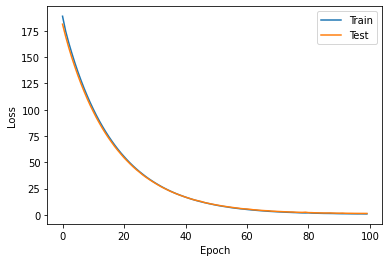

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')
plt.legend()
plt.show()

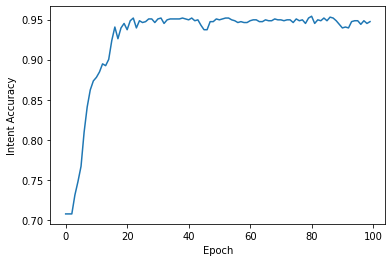

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Intent Accuracy')
plt.plot(intent_acc)
plt.show()

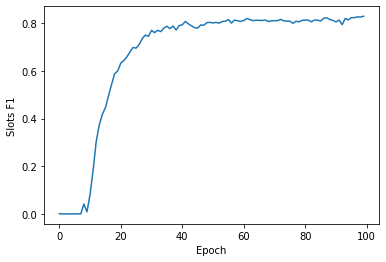

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Slots F1')
plt.plot(slots_f1)
plt.show()